<a href="https://colab.research.google.com/github/zaouiF/json/blob/master/tn_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

We will be fine tuning an existing GPT2 model using the interface Hugging Face provides. Fine tuning instead of retraining for a few very simple and pragmatic reasons. First among them these language models requre vast swaths of data and are computationally prohibitively expensive to train. However, by leveraging what is already available we can cut out both of these requirements. This means we can tweak the outputs of the model to suit specific purposes with minimal data and with achievable hardward. This is essentially transfer learning for language generation problems. To start off with we need to install the Huggingface transformers library first. Many of the common scientific libraries are pre-installed on Colab but not this one in particular. Installing transformers will also install tokenizers, a dependency, and another useful set of tools for this task.

In [ ]:
%%capture
!pip install transformers

# Create Training Set

We're going to use the flavor text of existing MTG cards to generate new ones. Luckily, the hard work of scraping the data has been done for us and we can ingest the flavor text from the [Scryfall](https://scryfall.com/advanced) API and quickly parson the json we are returned. 


In [ ]:
# We'll need these libraries to gather and shape the data.
import requests 
import pandas as pd
from itertools import compress


path_to_file ='text.txt'
with open(path_to_file, encoding = "utf-8") as file:
    t=file.readlines()
    cardValues = []
    for i in file:
      cardValues.append(t)
    


import pandas as pd



# I'll convert this to a data frame to visualize a few rows nicely
# mostly just a sanity check.
df = pd.DataFrame(t)

cards = df.copy()

In [ ]:
cards.columns = ['text']
t

['text\n',
 'ان شاء الله\n',
 'الحلقة لولة من طوكيو ڨول\n',
 'اوكاي\n',
 'ها انا زادا فمة حاجات فارغة والله هاني باش نهبط توا انا ها تو كي نروح نحكيوا\n',
 'انا مبلع بالفارغ\n',
 'على اقل انت عندك حاجات مهمة فيه\n',
 'بك متاعي باش يطرشق نحسو ها لازمني نلم فلوس و نشري دسيق دور\n',
 'اخدمو في ربع ساعة\n',
 'ما فيه شيء\n',
 'لازم لغو نبعثولها ليلة\n',
 'قد ما تنجم\n',
 'هاو في يدك من تو لغدوة التسعة متاع الصباح\n',
 'و نرتاح عينيا\n',
 'دخت انا والله تعبت مال بك ريت توا منجم نعمل ديسيجن حطى شي كنشيش باش يجيوا يعيوض لازم نرتاح\n',
 'ما فيها شيء\n',
 'اي معقول\n',
 'قال لي حاول تصغر فال اللي باش كي تتحت في أوراق تخوف اسباس كبيرة\n',
 'اش بيه\n',
 'عود رجععين اللي لغو لنيك 2 بواب\n',
 'اش يهبل فيك\n',
 'الصورة هذه في احدى الأحياء بالعاصمة راجل يخدم في المرمة في شانطي و مرتو كل نهار تجيب الفطور مع نص النهار و تجيب بنتها و ولدها الصغير و تجي تفطر مع راجلها\n',
 'كانت تنجم تطيبلو فطورو من الليل و يهزو معاه\n',
 'هنا تفهم انها البساطة كنز و انها المحبة و العشرة ماهيش ساهلة و انها التضحية ماهوش ب

# GPT2 Tokenizer

First a brief description of tokenization straight from the source, the Hugging Face [Tokenizers](https://github.com/huggingface/tokenizers) github page:

```
What is a Tokenizer

A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

We will be using the GPT-2 tokenizer to tokenize our flavor text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but we can specifically set them differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. The next cell will instantiate our tokenizer and provide an example encoding.

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('aubmindlab/aragpt2-base', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("صباح النور")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[311, 1734, 6100]

From the example above we can see that the example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the string, in this case one value per word. These values are easier to train the neural network model on than the string representation. We now have a corpus of flavour text we can iterate through, and a tokenizer, we should quickly inspect it to see what the longest string is, this will be useful later when we need to know how long to pad our sentences out to.


# PyTorch Datasets & Dataloaders


Different language models require different amounts of memory to hold all of the weights and biases in memory. Based on the memory your machine has available this will determine how you set your batch size. If your instance is running on a T4 GPU you can set batch to 32, but you may have to scale down if allocated a less powerful instance. 

In [ ]:
!nvidia-smi

Sat Jun 12 05:58:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
bs = 32

The batch size will affect the training time so it is always a good idea to set the batch to the highest number you can fit in the memory of the GPU you are using for training, however this hyper parameter should only affect training time but not model performance. A batch size too large won't fit in memory for some GPUS so you will have to adjust this parameter if you aren't allocated a T4 or K80.

The next thing to do is to create a custom dataloader for our corpus, we will follow the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation on this to create ```MTGDataset```.

In [ ]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class MTGDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="monsoon-nlp/sanaa", max_length=98):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

The maximum length of tokens is 768, however we don't need to use this length as we saw that the longest string we are encoding is only 98 words long. So to save space in the model we will only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. Next we will create the dataset itself using this class. Like I described above in the code each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask. This dataset will then be split into the training and validation sets.


In [ ]:
from torch.utils.data import random_split

dataset = MTGDataset(t, tokenizer, max_length=98)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 52271 samples for training, and 13068 samples for validation testing'

In [ ]:
dataset

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [ ]:
dataset[0]

(tensor([64000,    87, 22108,   202,     0, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001,
         64001, 64001, 64001, 64001, 64001, 64001, 64001, 64001]),
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('aubmindlab/aragpt2-base', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("aubmindlab/aragpt2-base", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [ ]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 100 of 1634. Loss:0.9763764142990112. Time:0:01:41
Example output:  الباقيتكتب كل شيء غير اللي يعرفنا شيء اكيد لا يفهم الناس اجمعين في مصر الا انا كان يعرف هاذي غير اني لا اتكلمش اعملوها هاذي هاذي شي من تونس لا نوما ما يتقرروا باش ما يعرفوش فيها شيء متاعكم من تونس و انا نعمل بيها مع المواطنين اللي تعمل بيها كلش عادك كل يوم باش نعطوهم في تونس كولو تاها شيء معينش يا ما تعرفو و خاصة بعد تونس باش ما فيها شيئ في تونس الكملو وقت ما تعرف الناس غير الكلام اللي ما تعرفو فيها حاجة و خاصة الناس و متاعك في حاجة برشة شوية تونسية في خاطر من اي فترة ما تاعش في تونس و حتى غير في تونس ما تعرفهماش الي لا شيء الا ما يعرفش باش يكون في تونس و لا يعرفو اللي مشو موجودين في تونس في تونس و ما لا شيء غير كلام الناس بعد تونس ما يكونش من أي شيء لكن بعد ما نقولو الناس بعد ساعة ما عاد ما عادش اي شيء مع الوقت و


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 200 of 1634. Loss:1.4040019512176514. Time:0:03:30
Example output: ينيينكل واحد ما يمكنش حتى في كل يوم و نحن من اليوم اللي نحبو و نعرفو في كل مرة كل شيء بسيط و في كل شيء متاع كل شيء يهمش في النهار التونسي في كل شي من اليوم واللي صار في النهار كل يوم وكل نهار من اليوم والناس الي ندور في تونس في النهار ما نعرفش كيفاش في كل شيء بسيط و لا يهمهمش ولا نعرفوا الحقيقة ومن غير منطقي ومعبي وو ما يعرفش من الحقيقة هوما نقعدو من بعد ما نموت وما نعرفش على واحد اللي ما يفهمش حتى في الحياة ما نفهموش كيفاش و كيفاش باش يعرفوه في حياتهم كل مرة واحد في حياتهم وما نعرفش في الدار و حتى نفهمو على كل شيء كيفاش و غير ما نحبش فيها هوما نعرفوش الحكاية اللي ندور في النهار وما نشبيها في النهار في كل شيء نفهمها و نحن نحن في الليل ما نعرفش فيهش كيفاش و نحن في الليل من اليوم اللي جايبش واحد في النهار و حتى من الصباح كان في حجر


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 300 of 1634. Loss:1.355130910873413. Time:0:05:19
Example output: فتيعني في مكان يخدمو ولا في الخارج ولا في الخارج



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 400 of 1634. Loss:0.9990910887718201. Time:0:07:06
Example output:  تجربتهخاصة و مافيش باش تخرج من باب الدار مالاغلبية



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 500 of 1634. Loss:1.1888196468353271. Time:0:08:53
Example output:  بجدةما عادش خويا ما عاداش و ما عادش هاو شيء هه وو جبتنيش حاجة خويا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 600 of 1634. Loss:0.7578120827674866. Time:0:10:40
Example output:  والل�اسودو دياركم في تونس مشا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 700 of 1634. Loss:0.9405247569084167. Time:0:12:27
Example output:  نقابةالشهرة إلي نجم فيها إلي هي إلي نجم هكة في قناتنا و قناتنا أكثر من خمسة سنوات و أكثر بش نرسملك في قناتنا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 800 of 1634. Loss:0.9958183169364929. Time:0:14:14
Example output: هاري



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 900 of 1634. Loss:1.0329310894012451. Time:0:16:00
Example output:  فائقعندك ساهلة محلاها هاذي حبتني كان ماته



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1000 of 1634. Loss:0.6689910888671875. Time:0:17:47
Example output: سجيلمعلم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1100 of 1634. Loss:0.7953939437866211. Time:0:19:34
Example output:  ينتهكصديكو دق 76



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1200 of 1634. Loss:0.889569878578186. Time:0:21:20
Example output:  بلطما يسكرش



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1300 of 1634. Loss:0.8718414902687073. Time:0:23:07
Example output: زيكفي إطار خطة أمريكية و أمريكية



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1400 of 1634. Loss:0.9682220816612244. Time:0:24:54
Example output:  التهمبالتوفيق ان شاء الله



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1500 of 1634. Loss:0.9033144116401672. Time:0:26:41
Example output: ليناي



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1600 of 1634. Loss:1.2979214191436768. Time:0:28:28
Example output:  المميزاتكريم شادلة

Average Training Loss: 1.0595871739025653. Epoch time: 0:29:03
Validation loss: 0.7935117617941719. Validation Time: 0:02:23
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 100 of 1634. Loss:0.8107580542564392. Time:0:01:47
Example output:  التصريحاترب يحمينا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 200 of 1634. Loss:0.5142589807510376. Time:0:03:34
Example output:  نحاحلى نور امين



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 300 of 1634. Loss:0.8257040977478027. Time:0:05:20
Example output: لانراجل



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 400 of 1634. Loss:0.9053298830986023. Time:0:07:07
Example output:  يوسفإلي ما لقيت ما قلت شنوة ما لقيتش ها المدونه من جديد وريني خويا زادا زادا كان ها التدوينه إلي صارت هي إلي عندي و إلي تحكي فيه



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 500 of 1634. Loss:0.8309661149978638. Time:0:08:54
Example output:  whخدامة و مزيانة



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 600 of 1634. Loss:0.9787625074386597. Time:0:10:41
Example output:  الاربعاءكلام صحيح



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 700 of 1634. Loss:0.8107263445854187. Time:0:12:28
Example output: ديادوالله عار على كل غيور على شعبه



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 800 of 1634. Loss:0.5888786911964417. Time:0:14:15
Example output:  فلسطينيينوالله عيب و ربي يكون على أخلاقكم و ربي يحفضكم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 900 of 1634. Loss:0.7555410861968994. Time:0:16:02
Example output:  بالمفنان ناجح واعي و من أحسن الممثلين في البلاد



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1000 of 1634. Loss:0.8333951234817505. Time:0:17:49
Example output:  التشكيليةهذا يدخل حد الوباء



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1100 of 1634. Loss:0.558089554309845. Time:0:19:36
Example output:  الطقسالميكير ك تشوفو الكلوش باش ما توفرولهم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1200 of 1634. Loss:0.7822617888450623. Time:0:21:22
Example output: �اركةقحب



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1300 of 1634. Loss:0.685971200466156. Time:0:23:09
Example output:  وحريةسدد الله خطاكم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1400 of 1634. Loss:0.714095413684845. Time:0:24:56
Example output:  متسبيهالله لا تربحك يا ربيي عل بوليس مااسط جايبينو ياخي يا جعفور و كلامو صحيح كل حاجة لا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1500 of 1634. Loss:0.6797019839286804. Time:0:26:43
Example output: عبدما شحمه الله و الله ما تلطف بيهم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1600 of 1634. Loss:0.8159812688827515. Time:0:28:30
Example output:  يغيرعطيوبة

Average Training Loss: 0.7435706842376085. Epoch time: 0:29:05
Validation loss: 0.7184764142432831. Validation Time: 0:02:24
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 100 of 1634. Loss:0.7496828436851501. Time:0:01:47
Example output:  نجومإستدعاء الفنانين في تونس



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 200 of 1634. Loss:0.598881185054779. Time:0:03:34
Example output:  والمتوسطةهذاكة موش قتلي كان نحي دمو



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 300 of 1634. Loss:0.6491476893424988. Time:0:05:21
Example output:  كوبيربي يحمي تونس و أهلها



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 400 of 1634. Loss:0.407758891582489. Time:0:07:07
Example output:  مقاتألمانيا عندها 69 حالة إنعاش و إنعاش و إنعاش و 700 مليون ساكن هنا و هذا يمثل 4 أهداف من وراء هذا يمثل 4 من وراء إنعاش



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 500 of 1634. Loss:0.6535628437995911. Time:0:08:55
Example output:  أفنيانا ما فقتش



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 600 of 1634. Loss:0.5489158630371094. Time:0:10:42
Example output:  ولدهما شاء الله عليها



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 700 of 1634. Loss:0.5803480744361877. Time:0:12:28
Example output: برافو



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 800 of 1634. Loss:0.7713974118232727. Time:0:14:15
Example output:  الفللرجل بكل خصال الرجولة والشهامة وحب العطاء الله يسليك



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 900 of 1634. Loss:0.6262574195861816. Time:0:16:02
Example output: حايابربي سؤال هل زار ت السياحه غير معنيه لانها الى حد الان لم تغل ق البيران ولا الوتله ولد سربي حتى العشر تاع الليل



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1000 of 1634. Loss:0.5537426471710205. Time:0:17:49
Example output:  يساعدبلا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1100 of 1634. Loss:0.5733129382133484. Time:0:19:36
Example output:  اكتسابنقول لها الحق في اي لحظة خاطر رانا في ايطاليا وبقية الدول محترمة الحجر الصحي و كل شي تعملوه في تونس والعالم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1200 of 1634. Loss:0.7633512616157532. Time:0:21:23
Example output:  2020ي



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1300 of 1634. Loss:0.4779297709465027. Time:0:23:10
Example output:  يحضربالتوفيق دكتور



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1400 of 1634. Loss:0.43948251008987427. Time:0:24:56
Example output: �وميبتبط يوتو ب دبااتنااناانسمة



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1500 of 1634. Loss:0.4917277991771698. Time:0:26:43
Example output:  شهادةهاذي نكرة و قداش تنجم



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1600 of 1634. Loss:0.4676280915737152. Time:0:28:30
Example output:  وآخربرافو

Average Training Loss: 0.6089950028437587. Epoch time: 0:29:05
Validation loss: 0.6636781667730336. Validation Time: 0:02:24
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 100 of 1634. Loss:0.5142074823379517. Time:0:01:47
Example output: جانيكلامو صحيح برافوو



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 200 of 1634. Loss:0.46466413140296936. Time:0:03:34
Example output: ثقفي إطار محاربة فيروس كورونا في تونس



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 300 of 1634. Loss:0.4941146969795227. Time:0:05:21
Example output:  شمالتعجبني



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 400 of 1634. Loss:0.5398553013801575. Time:0:07:07
Example output:  العلاقاتنسمة كورونا



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 500 of 1634. Loss:0.48303964734077454. Time:0:08:54
Example output:  تهددسلامتكوسلامتيمسؤليتناالكل



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 600 of 1634. Loss:0.4882400333881378. Time:0:10:41
Example output:  ومشماسطة و متكبر



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 700 of 1634. Loss:0.5324944853782654. Time:0:12:28
Example output:  وحلولي



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 800 of 1634. Loss:0.5394680500030518. Time:0:14:14
Example output:  سببهبجاه ربي نقصو علينا من كثرة الاشهار فى خليل تونس رانا كرهنا نسمة وكرهنا نتفرج فيها ولات قنات طلبة فقط



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 900 of 1634. Loss:0.5661144256591797. Time:0:16:02
Example output:  وجهاتبرشة ضحك برافو



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1000 of 1634. Loss:0.40894147753715515. Time:0:17:48
Example output:  استئممسطها مرا وعليها لكلام



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1100 of 1634. Loss:0.5123432278633118. Time:0:19:35
Example output:  الاسرائيليةيا دكتور نسعدو المرحلة هاذي



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1200 of 1634. Loss:0.6548138856887817. Time:0:21:22
Example output:  رصاصالمعمل تخدم بال الف موش محصوبين فداول وماعندمشههش بلاصة فلخررية



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1300 of 1634. Loss:0.5589815378189087. Time:0:23:09
Example output:  ولمربي يقدر الخير



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1400 of 1634. Loss:0.41205766797065735. Time:0:24:56
Example output: ورطينكفر فو 24 24 يرحم والديكم خير مبهد مانندمو



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1500 of 1634. Loss:0.36451253294944763. Time:0:26:42
Example output:  ويافشل



Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Batch 1600 of 1634. Loss:0.5425718426704407. Time:0:28:29
Example output:  الإسلاميينشيخنا عبد الفتاح مورو مشى يشطح على روحو و من بعدو شيخ من أصل عرق آخر و هو يقاسي و مناضل

Average Training Loss: 0.4880859901902871. Epoch time: 0:29:05
Validation loss: 0.6514569288506776. Validation Time: 0:02:24
Total training took 2:05:54


Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

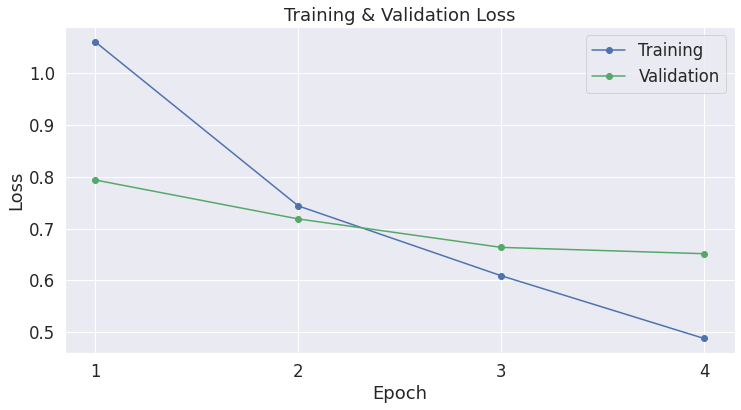

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Saving & Loading Fine-Tuned Model

Next it is a good idea to move the model we have trained and the associated weights, biases and model parameters out of the Colab space and into our own google drives. The cell below will mount your drive for you, then you can save the model using the prebuilt Hugging Face and PyTorch functionalities.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

output_dir = '/content/drive/MyDrive/models/fatma_gpt2/modelTN12-06-2021'
args=0
# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
torch.save(args ,os.path.join(output_dir, 'training_args.bin'))

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Generate Text

Lastly the fun part! We will now generate samples from our model to test how well our model performs!

In [ ]:
model.eval()

prompt = " سلام وينك" 
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=45, 
                                max_length = 30,
                                top_p=0.90, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


0:  سلام وينك لباس



1:  سلام وينك



2:  سلام وينك لباس





If you are familiar with MTG then you can evaluate these for yourself to determine how well the model has worked, or if you have modified the code to accept your own data input for a specific task this is what you are looking to evaluate for your own uses. Lastly, if you want to load the model you have saved to your google drive, the next cell will load the fine tuned GPT2 model and tokenizer, this means you can also share your model with other!

In [ ]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64002, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
